In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
import librosa as lr
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import pylab, librosa.display, utils

utils.py correctly charged


Le but est ici d'extraire les caractéristiques du MFCC des fichiers audio provenant de la base de données TIMIT, afin de les utiliser en implémentant un algorithme de clustering pour au final prédire de quelle manière l'algorithme définit ses clusters 

#     Création des DataFrames

Nous avons récupérer les données contenues dans les fichiers train.csv et test.csv. À l'aide de la librairie Pandas contenant plusieurs fonctions qui permettent de manipuler des données, nous pouvons créé nos dataframes


In [2]:
df_train = pd.read_csv("train.csv", "|")
df_test = pd.read_csv("test.csv", "|")

le dataset est séparé en deux parties :
- un ensemble d'apprentissage (environ 73% des données), qui va permettre d'entraîner le modèle
- un ensemble de test (environ 26% des données), qui va permettre d'estimer la pertinence de la prédiction

Affichons grâce à la fonction head(), l'entête d'un dataframe pour vérifier s'il a bien été chargé 

In [3]:
df_train.head()

,soundName,personName,TRN/TST,soundPath,wrdPath,phnPath,txtPath,gender,region,age,recordDate,birthDate,height,race,education,prompt,start,end
0,sa1,ABC0,TRN,TIMIT/TRAIN/DR6/MABC0/SA1.wav,TIMIT/TRAIN/DR6/MABC0/SA1.wrd,TIMIT/TRAIN/DR6/MABC0/SA1.phn,TIMIT/TRAIN/DR6/MABC0/SA1.txt,M,New York City,25,03/03/86,06/17/60,180.34,WHT,BS,She had your dark suit in greasy wash water all,0,43418
1,sa2,ABC0,TRN,TIMIT/TRAIN/DR6/MABC0/SA2.wav,TIMIT/TRAIN/DR6/MABC0/SA2.wrd,TIMIT/TRAIN/DR6/MABC0/SA2.phn,TIMIT/TRAIN/DR6/MABC0/SA2.txt,M,New York City,25,03/03/86,06/17/60,180.34,WHT,BS,Don't ask me to carry an oily rag like,0,35840
2,sx331,ABC0,TRN,TIMIT/TRAIN/DR6/MABC0/SX331.wav,TIMIT/TRAIN/DR6/MABC0/SX331.wrd,TIMIT/TRAIN/DR6/MABC0/SX331.phn,TIMIT/TRAIN/DR6/MABC0/SX331.txt,M,New York City,25,03/03/86,06/17/60,180.34,WHT,BS,The big dog loved to chew on the old rag,0,39322
3,sx61,ABC0,TRN,TIMIT/TRAIN/DR6/MABC0/SX61.wav,TIMIT/TRAIN/DR6/MABC0/SX61.wrd,TIMIT/TRAIN/DR6/MABC0/SX61.phn,TIMIT/TRAIN/DR6/MABC0/SX61.txt,M,New York City,25,03/03/86,06/17/60,180.34,WHT,BS,Chocolate and roses never fail as a romantic,0,39936
4,sx241,ABC0,TRN,TIMIT/TRAIN/DR6/MABC0/SX241.wav,TIMIT/TRAIN/DR6/MABC0/SX241.wrd,TIMIT/TRAIN/DR6/MABC0/SX241.phn,TIMIT/TRAIN/DR6/MABC0/SX241.txt,M,New York City,25,03/03/86,06/17/60,180.34,WHT,BS,The hallway opens into a huge,0,31949


# Visualisation et Traitement des données

Affichons les dimensions des différents dataframes grâce à la fonction shape

In [4]:
print("Shape of training data : ", df_train.shape)
print("Shape of testing data  : ", df_test.shape)

Shape of training data :  (4620, 18)
Shape of testing data  :  (1680, 18)


In [5]:
df_train.info() # regardons toutes les informations sur notre dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4620 entries, 0 to 4619
Data columns (total 18 columns):
soundName     4620 non-null object
personName    4620 non-null object
TRN/TST       4620 non-null object
soundPath     4620 non-null object
wrdPath       4620 non-null object
phnPath       4620 non-null object
txtPath       4620 non-null object
gender        4620 non-null object
region        4620 non-null object
age           4620 non-null int64
recordDate    4620 non-null object
birthDate     4620 non-null object
height        4620 non-null float64
race          4620 non-null object
education     4620 non-null object
prompt        4620 non-null object
start         4620 non-null int64
end           4620 non-null int64
dtypes: float64(1), int64(3), object(14)
memory usage: 649.8+ KB


Supprimons à l'aide de la fonction drop(), les colonnes non pertinentes pour la prédiction

In [6]:
df_train = df_train.drop(['personName','soundName','txtPath','phnPath','wrdPath','TRN/TST','recordDate','birthDate','height','education','prompt','start','end'], axis = 1)
df_test = df_test.drop(['personName','soundName','txtPath','phnPath','wrdPath','TRN/TST','recordDate','birthDate',
'height','education','prompt','start','end'], axis = 1)
# axis = 1 pour supprimer des colonnes et axis = 0 pour supprimer des lignes

La plupart des algorithmes ont besoin de données numériques, et n'acceptent pas les chaînes de caractères. Ainsi, la fonction map() nous permettra d'attribuer des valeurs numériques à des chaînes de caractères

Premièrement, appliquons la fonction map sur le sexe (gender):

   . "M" => 0 (M = male)
   . "F" => 1 (F = Female)
   
Ensuite attribuons des valeurs numériques aux différentes régions:

    .region: New York City => 0
    .region: New England => 1
    .region: Northern => 2
    .region: North Midlan => 3
    .region: South Midland => 4
    .region: Southern => 5
    .region: Western => 6
    .region: Army Brat => 7
    
Enfin, faisons de même pour les races:
    
    -WHT => 0
    -??? => 1
    -ORN => 2 
    -AMR => 3   
    -SPN => 4   
    -HSP => 5   
    -HIS => 6    

In [7]:
df_train['gender'] = df_train.gender.map({'M':0, 'F':1})
df_test['gender'] = df_test.gender.map({'M':0, 'F':1})

df_train['race'] = df_train.race.map({'WHT':0, '???':1, 'ORN':2, 'AMR':3, 'SPN':4, 'HSP':5, 'HIS':6})
df_test['race'] = df_test.race.map({'WHT':0, '???':1, 'ORN':2, 'AMR':3, 'SPN':4, 'HSP':5, 'HIS':6})

                                     

In [8]:
df_train['region'] = df_train.region.map({'New York City':0, 'New England':1, 'Northern':2, 'North Midlan':3, 'South Midland':4, 'Southern':5, 'Western':6, 'Army Brat':7})


In [9]:
df_test['region'] = df_test.region.map({'New York City':0, 'New England':1, 'Northern':2, 'North Midlan':3, 'South Midland':4, 'Southern':5, 'Western':6, 'Army Brat':7})

In [10]:
df_train.head() # vérifions si nos donées ont bien été chargées

,soundPath,gender,region,age,race
0,TIMIT/TRAIN/DR6/MABC0/SA1.wav,0,0.0,25,0.0
1,TIMIT/TRAIN/DR6/MABC0/SA2.wav,0,0.0,25,0.0
2,TIMIT/TRAIN/DR6/MABC0/SX331.wav,0,0.0,25,0.0
3,TIMIT/TRAIN/DR6/MABC0/SX61.wav,0,0.0,25,0.0
4,TIMIT/TRAIN/DR6/MABC0/SX241.wav,0,0.0,25,0.0


Dans le dataframe df_train, l'on constate que certains âges sont négatifs (= -1). Il faut donc les traiter et pour cela nous allons calculer la moyenne des âges et remplacer les valeurs -1 par cette moyenne

In [11]:
df_train = df_train.replace(-1,np.nan)
values = {'age':round(df_train.age.mean())}
df_train = df_train.fillna(value=values)

In [12]:
df_train.describe() # affichons les statistiques du dataframe et vérifions si les valeurs ont bien été chargé
# en effet oui car le min de la série age est égal à 20

,gender,region,age,race
count,4620.000000,3640.000000,4620.000000,4440.000000
mean,0.294372,3.500000,29.722944,0.094595
std,0.455809,2.025531,7.712710,0.537042
min,0.000000,0.000000,20.000000,0.000000
25%,0.000000,2.000000,25.000000,0.000000
50%,0.000000,4.000000,27.000000,0.000000
75%,1.000000,5.000000,32.000000,0.000000
max,1.000000,6.000000,75.000000,6.000000


In [13]:
df_train.count() 

soundPath    4620
gender       4620
region       3640
age          4620
race         4440
dtype: int64

In [14]:
df_test.count()

soundPath    1680
gender       1680
region       1310
age          1680
race         1600
dtype: int64

L'on peut constater qu'on a des valeurs manquantes dans nos 2 dataframes au niveau de la region et la race. Il faudrait donc faire une estimation des données manquantes avant toute analyse finale.

Avant cela, Vérifions que les données de train et de test sont correctement équilibrées à l'aide de graphiques ( visualisation des répartitions)

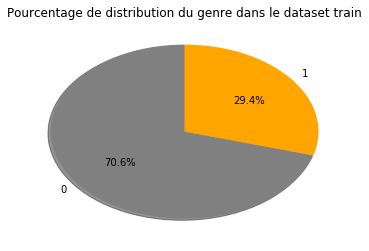

0    3260
1    1360
Name: gender, dtype: int64

In [15]:
type = df_train.gender.value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['grey', 'orange']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pourcentage de distribution du genre dans le dataset train")
plt.show()

df_train.gender.value_counts()

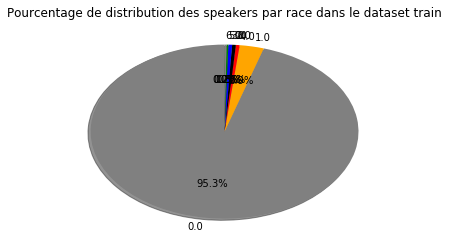

0.0    4230
1.0     130
4.0      20
2.0      20
3.0      20
5.0      10
6.0      10
Name: race, dtype: int64

In [16]:
type = df_train.race.value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['grey', 'orange', 'red', 'black', 'blue', 'green']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pourcentage de distribution des speakers par race dans le dataset train")
plt.show()
df_train.race.value_counts()

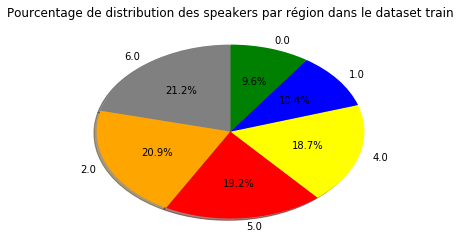

6.0    770
2.0    760
5.0    700
4.0    680
1.0    380
0.0    350
Name: region, dtype: int64

In [17]:
type = df_train.region.value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['grey', 'orange', 'red', 'yellow', 'blue', 'green']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pourcentage de distribution des speakers par région dans le dataset train")
plt.show()

df_train.region.value_counts()

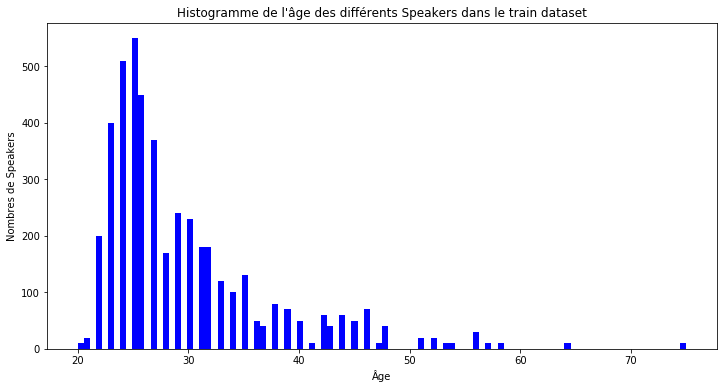

In [18]:
plt.figure(figsize=(12,6))                 
plt.hist(df_train.age, color='blue', bins=100)                     
plt.ylabel('Nombres de Speakers')
plt.xlabel('Âge')
plt.title('Histogramme de l\'âge des différents Speakers dans le train dataset')      
plt.show()

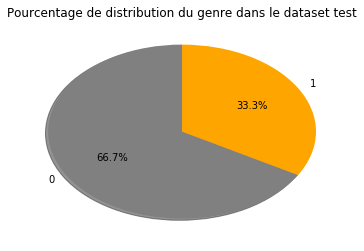

0    1120
1     560
Name: gender, dtype: int64

In [19]:
type = df_test.gender.value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['grey', 'orange']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pourcentage de distribution du genre dans le dataset test")
plt.show()

df_test.gender.value_counts()

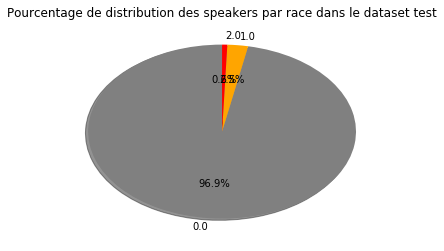

0.0    1550
1.0      40
2.0      10
Name: race, dtype: int64

In [20]:
type = df_test.race.value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['grey', 'orange', 'red']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pourcentage de distribution des speakers par race dans le dataset test")
plt.show()
df_test.race.value_counts()

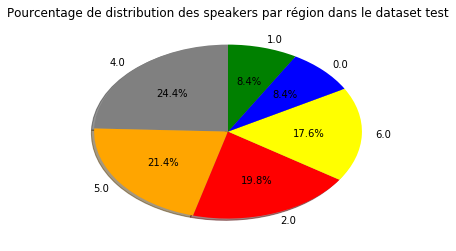

4.0    320
5.0    280
2.0    260
6.0    230
0.0    110
1.0    110
Name: region, dtype: int64

In [21]:
type = df_test.region.value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['grey', 'orange', 'red', 'yellow', 'blue', 'green']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pourcentage de distribution des speakers par région dans le dataset test")
plt.show()

df_test.region.value_counts()

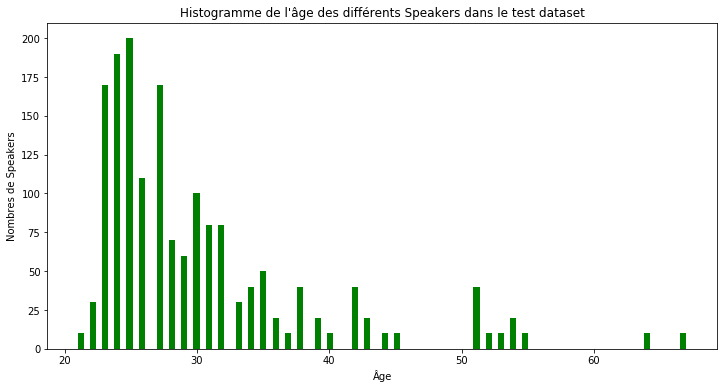

In [22]:
plt.figure(figsize=(12,6))                 
plt.hist(df_test.age, color='green', bins=100)                     
plt.ylabel('Nombres de Speakers')
plt.xlabel('Âge')
plt.title('Histogramme de l\'âge des différents Speakers dans le test dataset')      
plt.show()

Repartissons les âges grâce à un diagramme en camembert. Avant cela, créons une nouvelle colonne en fonctions de l'age moyenne dans le dataframe ( younger_than_mean_age ) qui vaut 1 si l'age est inférieur à l'âge moyenne sinon 0

In [23]:
print('Mean age of the speakers in the train dataset :', round(df_train.age.mean()))
df_train['younger_than_mean_age'] = df_train.age.map(lambda age: 1 if age < round(df_train.age.mean()) else 0)
df_test['younger_than_mean_age'] = df_test.age.map(lambda age: 1 if age < round(df_train.age.mean()) else 0)

Mean age of the speakers in the train dataset : 30


In [24]:
df_train.younger_than_mean_age.value_counts()

1    2920
0    1700
Name: younger_than_mean_age, dtype: int64

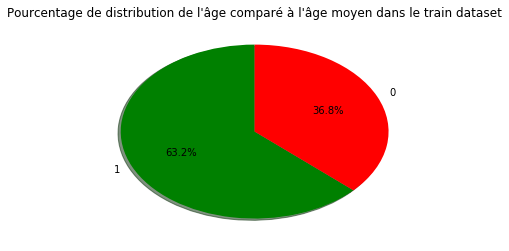

1    2920
0    1700
Name: younger_than_mean_age, dtype: int64

In [25]:
type = df_train['younger_than_mean_age'].value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['green', 'red']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pourcentage de distribution de l'âge comparé à l'âge moyen dans le train dataset")
plt.show()

df_train['younger_than_mean_age'].value_counts()

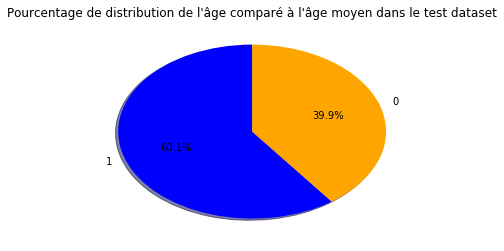

1    1010
0     670
Name: younger_than_mean_age, dtype: int64

In [26]:
type = df_test['younger_than_mean_age'].value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['blue', 'orange']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pourcentage de distribution de l'âge comparé à l'âge moyen dans le test dataset")
plt.show()

df_test['younger_than_mean_age'].value_counts()

Ici, nous voyons clairement que les données ne sont pas équilibrées, ce qui pourrait nuire à l'apprentissage de nos modèles. Nous supprimerons donc les données au hasard pour les rééquilibrer toutes les colonnes

Complétons tout d'abord les données manquants récemments vues.
La fonction *fillna* permet de compléter simplement les paramètres manquants. L'option *method='pad'* permet d'utiliser la précédente valeur non manquante

In [27]:
df_train = df_train.fillna(method='pad')
df_test = df_test.fillna(method='pad') 

In [28]:
df_train.count() # les données ont bien été complété

soundPath                4620
gender                   4620
region                   4620
age                      4620
race                     4620
younger_than_mean_age    4620
dtype: int64

# Visualisation des nouvelles données 

Ses graphiques ne concernent que les séries region et race

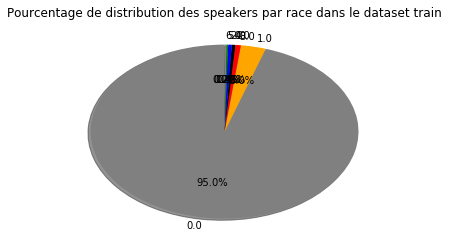

0.0    4390
1.0     140
3.0      30
4.0      20
2.0      20
5.0      10
6.0      10
Name: race, dtype: int64

In [29]:
type = df_train.race.value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['grey', 'orange', 'red', 'black', 'blue', 'green']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pourcentage de distribution des speakers par race dans le dataset train")
plt.show()
df_train.race.value_counts()

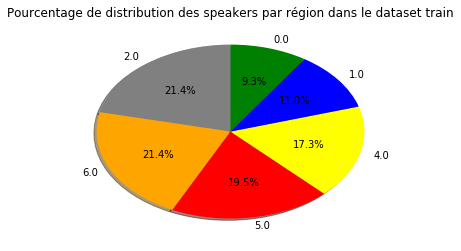

2.0    990
6.0    990
5.0    900
4.0    800
1.0    510
0.0    430
Name: region, dtype: int64

In [30]:
type = df_train.region.value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['grey', 'orange', 'red', 'yellow', 'blue', 'green']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pourcentage de distribution des speakers par région dans le dataset train")
plt.show()

df_train.region.value_counts()

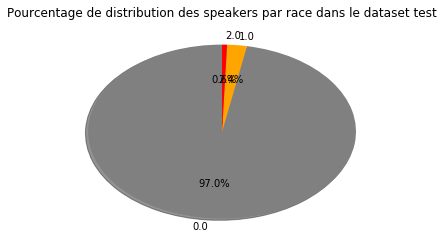

0.0    1630
1.0      40
2.0      10
Name: race, dtype: int64

In [31]:
type = df_test.race.value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['grey', 'orange', 'red']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pourcentage de distribution des speakers par race dans le dataset test")
plt.show()
df_test.race.value_counts()

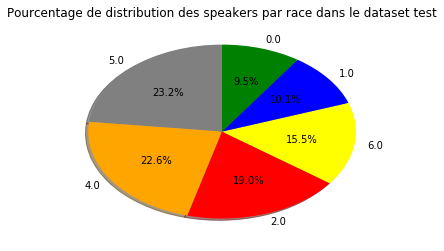

5.0    390
4.0    380
2.0    320
6.0    260
1.0    170
0.0    160
Name: region, dtype: int64

In [32]:
type = df_test.region.value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['grey', 'orange', 'red','yellow','blue','green']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pourcentage de distribution des speakers par race dans le dataset test")
plt.show()
df_test.region.value_counts()

# Extraction des caractéristiques des fichiers audio

Récupérons tous les chemins des fichiers audio afin d'extraire les MFCCs de chaque fichier audio pour créer nos données de d'entraînement et de test. les MFCCs sont calculés en utilisant la bibliothèque librosa ( librairie qui permet d'extraire les caractéristiques d'un fichier audio)

In [33]:
train_audio_list = df_train.soundPath.tolist() # liste les chemins des fichiers audio
test_audio_list = df_test.soundPath.tolist()

In [34]:
train_temp_features = []
test_temp_features = []

for elt in train_audio_list:
    train_temp_features.append(utils.extract_features(elt))

for elt in test_audio_list:
    test_temp_features.append(utils.extract_features(elt))

# Préparation des données d'entraînement et de test

In [35]:
X_train = np.array(train_temp_features)
y1_train = np.array(df_train.gender.tolist())
y2_train = np.array(df_train.race.tolist())
y3_train = np.array(df_train.region.tolist())
y4_train = np.array(df_train.age.tolist())

X_test = np.array(test_temp_features)
y1_test = np.array(df_test.gender.tolist())
y2_test = np.array(df_test.race.tolist())
y3_test = np.array(df_test.region.tolist())
y4_test = np.array(df_test.age.tolist())

# Visualisation des données par région

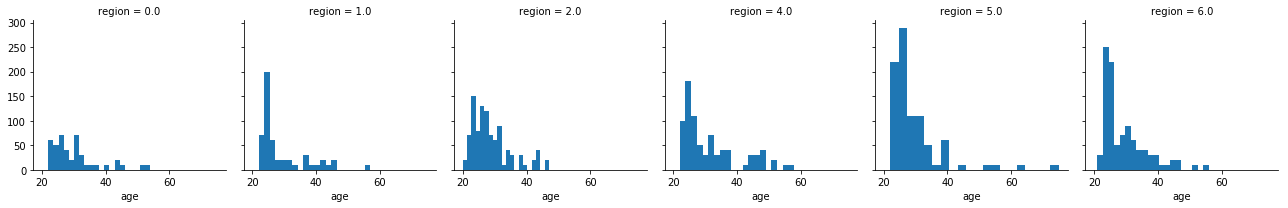

In [36]:
g = sns.FacetGrid(df_train, col='region') #visualisation des âges par region
g.map(plt.hist, 'age', bins=20)

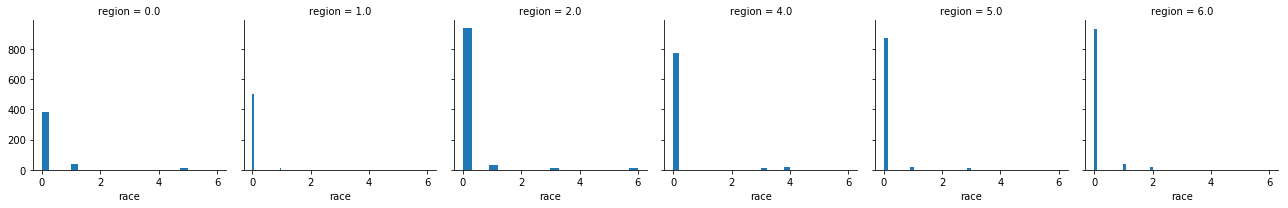

In [37]:
g = sns.FacetGrid(df_train, col='region')
g.map(plt.hist, 'race', bins=20)

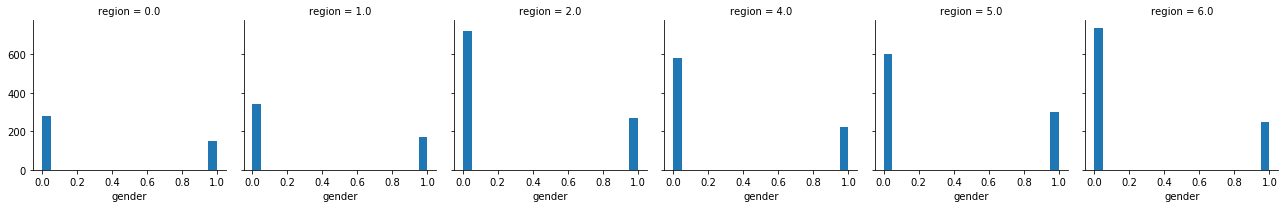

In [38]:
g = sns.FacetGrid(df_train, col='region') # visualisation du nombre d'homme et femme par région
g.map(plt.hist, 'gender', bins=20)

# KMeans Clustering 

Le véritable problème lors de l'utilisation d'un algorithme de clustering, c'est la détermination du nombre K de clusters. Ainsi, l'on peut faire une Sélection du nombre de clusters avec analyse de silhouette qui est utilisé pour étudier la distance de séparation entre les groupes résultants. La silhouette affiche une mesure de la proximité de chaque point d'une grappe par rapport à celle des grappes voisines et permet ainsi d'évaluer les paramètres tels que le nombre de grappes de manière visuelle

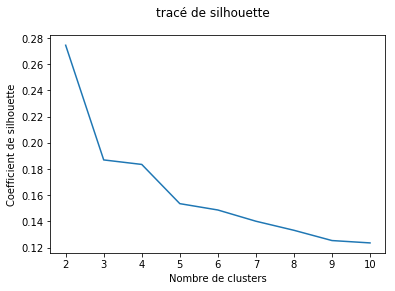

In [104]:
def sc_evaluate_clusters(X_train, max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2, max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X_train)
        s[k] = metrics.silhouette_score(X_train, kmeans.labels_, metric='euclidean')
    fig, ax = plt.subplots()
    ax.plot(range(2,len(s)),s[2:])
    ax.set_xlabel('Nombre de clusters')
    ax.set_ylabel('Coefficient de silhouette')
    ax.set_xticks(range(2, max_clusters+1))
    fig.suptitle('tracé de silhouette')
    
sc_evaluate_clusters(X_train, 10)

For n_clusters = 2 The average silhouette_score is : 0.2744570145177296
For n_clusters = 3 The average silhouette_score is : 0.1869542489020533
For n_clusters = 4 The average silhouette_score is : 0.18340851013465356
For n_clusters = 5 The average silhouette_score is : 0.15379700465909885
For n_clusters = 6 The average silhouette_score is : 0.15006133251012466


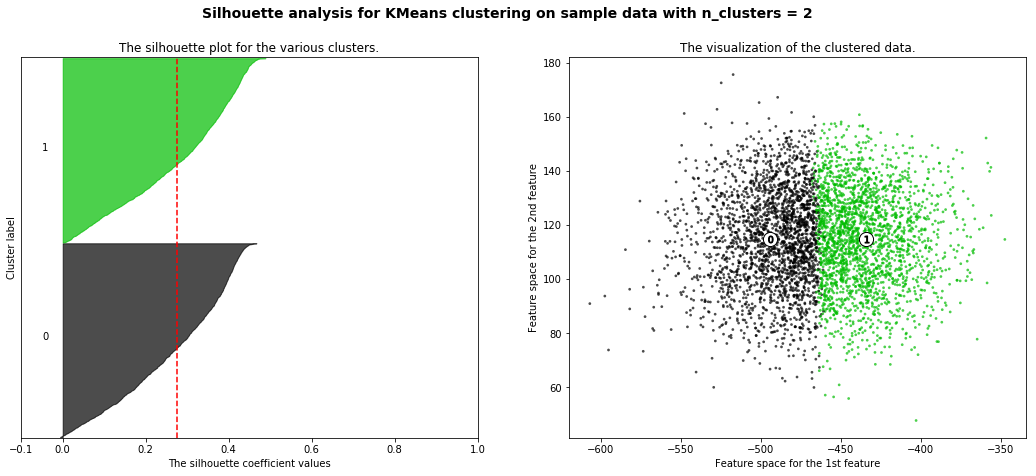

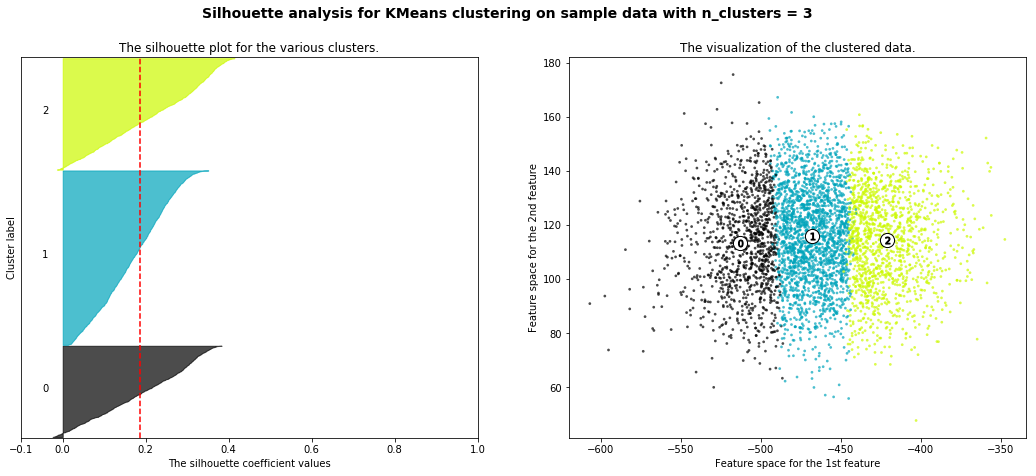

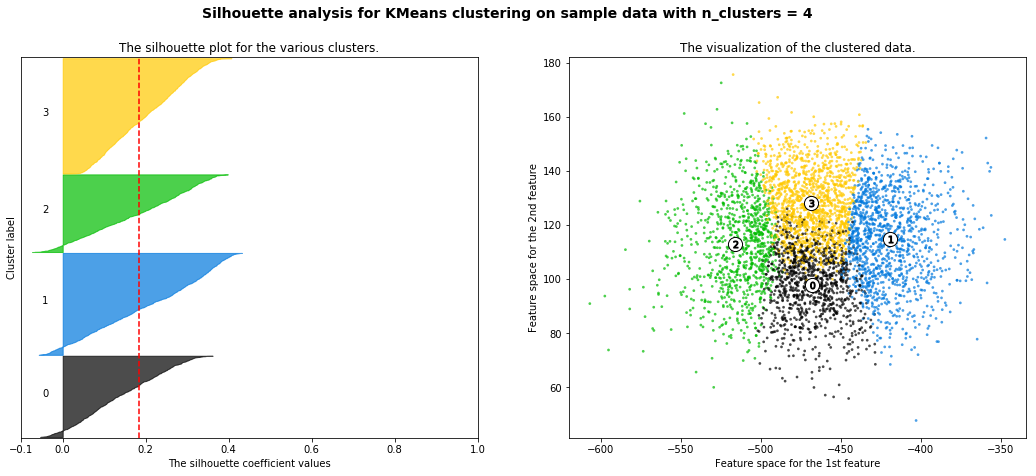

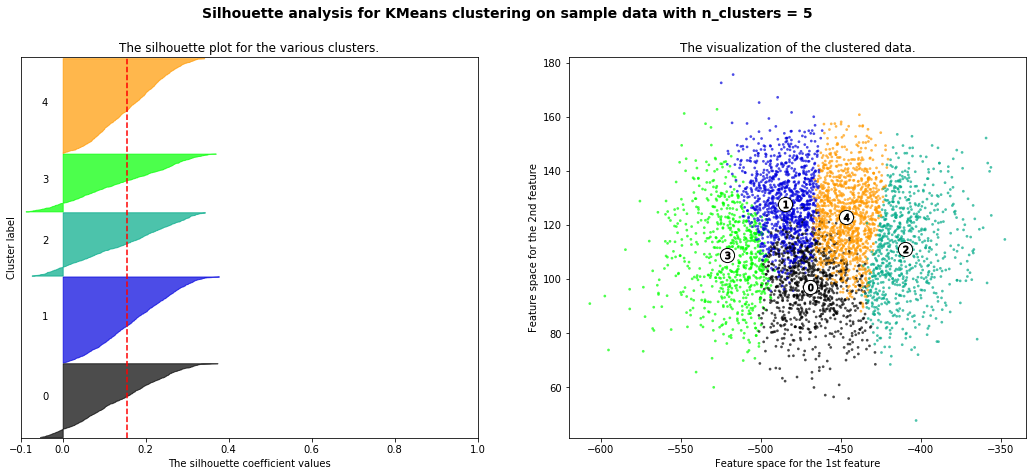

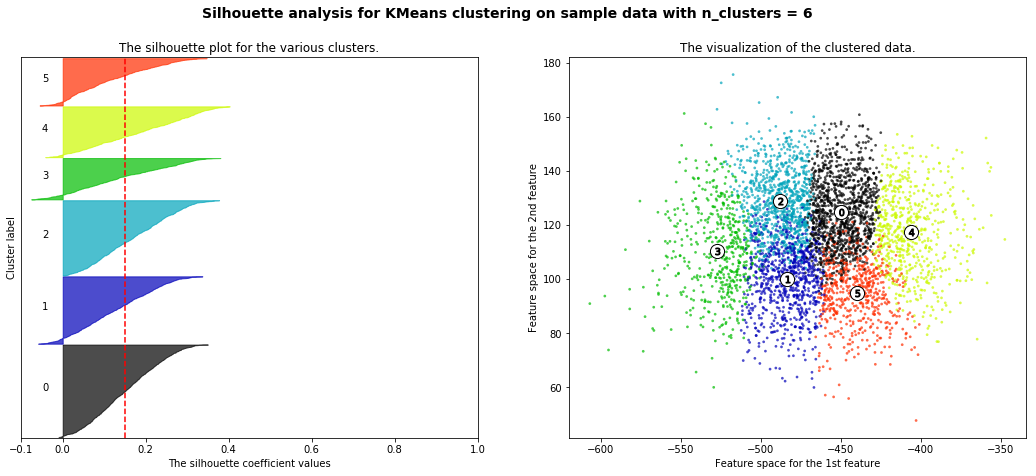

In [40]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0,1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_train[:, 0], X_train[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# KMeans Clustering sur le genre

Essayons dans un premier temps d'appliquer l'algorithme de clustering KMeans sur le genre pour ainsi visualiser le nombre de clusters

In [41]:
# Nous voulons regrouper les enregistrements du genre en 2 clusters : Féminin ou masculin
kmeans = KMeans(n_clusters= 2, max_iter=600, algorithm = 'auto') 
Kmeans = kmeans.fit(X_train)
print(Kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [42]:
labels = Kmeans.predict(X_train)
print(labels)

[1 1 1 ... 1 1 1]


In [43]:
Centroids = Kmeans.cluster_centers_
print(Centroids)

[[-4.94004308e+02  1.14639296e+02 -4.98334824e+01  2.92501844e+01
  -3.20130788e+01 -2.35743283e+00 -1.84696400e+01 -1.14416503e+01
  -7.00080467e+00 -9.38414558e+00 -1.89927661e+00 -1.06374228e+01
   3.14089898e-01 -8.49204269e+00  5.13602359e-01 -5.00168194e+00
  -4.43177456e+00 -1.57294600e+00 -4.82814954e+00 -1.60798437e+00
  -6.12374689e+00 -1.21524390e+00 -4.44810963e+00 -2.40445859e+00
  -2.48924870e+00 -2.72401336e+00 -1.21179786e+00 -2.19803495e+00
   1.37004494e-01 -1.23776167e+00  1.97641203e-01 -1.96952692e-01
   6.50540405e-01  7.05541336e-01  5.46015276e-01  8.37971106e-01
  -5.80957890e-03  2.26590648e-01 -4.17655192e-01 -2.47148339e-01]
 [-4.34399543e+02  1.15020206e+02 -5.29362328e+01  2.51470957e+01
  -3.03604080e+01 -7.34809692e+00 -1.78606077e+01 -1.39775235e+01
  -9.21461384e+00 -8.97463880e+00 -3.67096720e+00 -1.05931793e+01
   1.44311848e-01 -9.27207867e+00 -4.29231681e-01 -4.39631593e+00
  -5.61679293e+00 -2.33552948e+00 -4.35239825e+00 -2.40783156e+00
  -6.5016

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


Text(0.5,0.98,'Ensemble des points de données initialement')

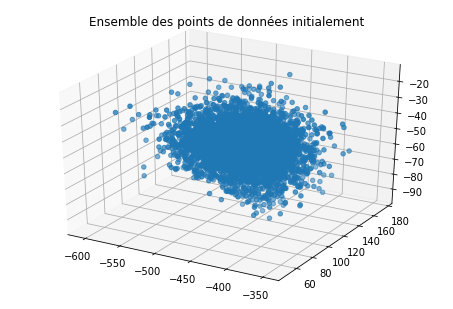

In [103]:
from mpl_toolkits.mplot3d import Axes3D # nuage de points de l'ensemble des données avant le clustering
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3])
fig.suptitle('Ensemble des points de données initialement')


In [45]:
n_clusters = 2
sc = metrics.silhouette_score(X_train, labels, metric='euclidean')
print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, sc))

For n_clusters = 2, silhouette score is 0.27444999278957943)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


Text(0.5,0.98,'KMeans sur le sexe')

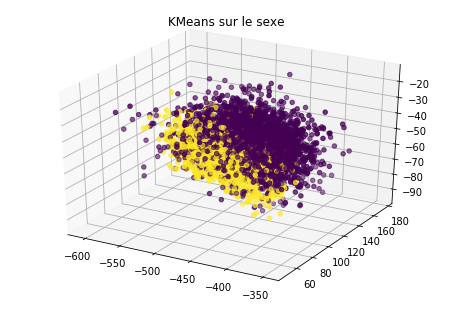

In [99]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3], c=y1_train)
ax.scatter(Centroids[:, 0], Centroids[:, 1], Centroids[:, 2], Centroids[:, 3], marker='*', c='#050505', s=1000)
fig.suptitle('KMeans sur le sexe')




# Clustering sur la region

In [47]:
kmeans = KMeans(n_clusters= 8, max_iter=600, algorithm = 'auto') 
Kmeans = kmeans.fit(X_train)
print(Kmeans)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [48]:
labels = Kmeans.predict(X_train)
print(labels)

[0 3 3 ... 3 3 0]


In [49]:
Centroids = Kmeans.cluster_centers_
print(Centroids)

[[-3.99834102e+02  1.13502423e+02 -5.43913291e+01  2.42046988e+01
  -3.03180400e+01 -8.80158867e+00 -1.76433090e+01 -1.57091893e+01
  -9.90423886e+00 -8.58022383e+00 -4.78419168e+00 -1.04375370e+01
   3.73544892e-01 -9.96360815e+00 -7.45395830e-01 -4.09555262e+00
  -6.52846460e+00 -2.80066208e+00 -3.96865822e+00 -3.09804274e+00
  -6.81696280e+00 -9.58880501e-01 -4.81438341e+00 -3.53696046e+00
  -2.65803347e+00 -3.36739742e+00 -2.56986102e+00 -3.24721245e+00
  -1.23956897e+00 -2.95196156e+00 -1.43486780e+00 -2.08121976e+00
  -1.77882007e+00 -1.59747538e+00 -2.05846995e+00 -1.48565369e+00
  -2.02306266e+00 -1.50667477e+00 -1.65777625e+00 -1.31008869e+00]
 [-5.32979739e+02  1.02113325e+02 -4.77651556e+01  3.23404083e+01
  -3.46233065e+01 -3.50520546e-01 -1.87402101e+01 -9.43518928e+00
  -4.92663710e+00 -1.06355973e+01 -1.73452026e+00 -1.01594997e+01
  -2.28692106e-01 -7.62091756e+00  5.30668070e-01 -6.27458795e+00
  -3.06920658e+00 -1.64087799e+00 -5.50668625e+00 -1.27351119e+00
  -5.7174

In [50]:
n_clusters = 8
sc = metrics.silhouette_score(X_train, labels, metric='euclidean')
print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, sc))

For n_clusters = 8, silhouette score is 0.13379650983210087)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


Text(0.5,0.98,'KMeans sur le région')

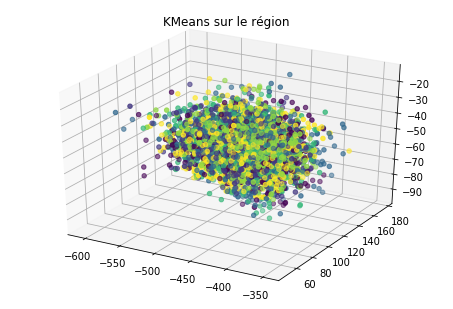

In [100]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3], c=y3_train)
ax.scatter(Centroids[:, 0], Centroids[:, 1], Centroids[:, 2], Centroids[:, 3], marker='*', c='#050505', s=1000)
fig.suptitle('KMeans sur le région')

l'on peut donc constater qu'il est presque impossible de faire du clustering sur la région

# Clustering sur l'age

In [52]:
kmeans = KMeans(n_clusters= 2, max_iter=600, algorithm = 'auto') 
Kmeans = kmeans.fit(X_train)
print(Kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [53]:
labels = Kmeans.predict(X_train)
print(labels)
Centroids = Kmeans.cluster_centers_
print('\nCentroids')
print(Centroids)



[0 0 0 ... 0 0 0]

Centroids
[[-4.34412725e+02  1.15013008e+02 -5.29435966e+01  2.51599893e+01
  -3.03606212e+01 -7.34874838e+00 -1.78571885e+01 -1.39762328e+01
  -9.21416295e+00 -8.97261067e+00 -3.67490713e+00 -1.05937645e+01
   1.45797766e-01 -9.27313227e+00 -4.28653416e-01 -4.39783609e+00
  -5.61688184e+00 -2.33496984e+00 -4.35137348e+00 -2.40859796e+00
  -6.50091641e+00 -1.18529831e+00 -4.59930532e+00 -3.14333391e+00
  -2.45724321e+00 -3.14087869e+00 -1.83166038e+00 -2.54472653e+00
  -6.74175805e-01 -1.95612519e+00 -6.82689601e-01 -1.26614216e+00
  -7.64682508e-01 -8.03171198e-01 -1.08474285e+00 -6.78497141e-01
  -1.39372550e+00 -9.47890404e-01 -1.28108086e+00 -1.02102236e+00]
 [-4.94016941e+02  1.14645997e+02 -4.98251492e+01  2.92396254e+01
  -3.20135743e+01 -2.35470146e+00 -1.84731576e+01 -1.14418088e+01
  -7.00029852e+00 -9.38625254e+00 -1.89477080e+00 -1.06368836e+01
   3.12744881e-01 -8.49070828e+00  5.13449651e-01 -5.00048846e+00
  -4.43118873e+00 -1.57315716e+00 -4.82932780e

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


Text(0.5,0.98,"KMeans sur l'âge")

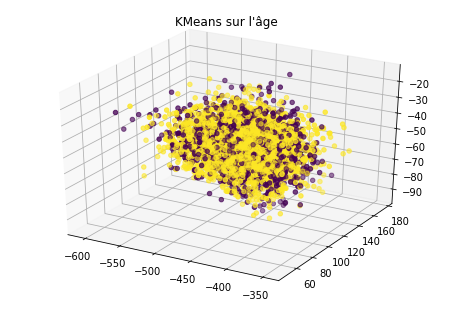

In [101]:
y5_train = np.array(df_train.younger_than_mean_age.tolist())
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3], c=y5_train)
ax.scatter(Centroids[:, 0], Centroids[:, 1], Centroids[:, 2], Centroids[:, 3], marker='*', c='#050505', s=1000)
fig.suptitle('KMeans sur l\'âge')

# Clustering sur la race


In [55]:
kmeans = KMeans(n_clusters= 7, max_iter=600, algorithm = 'auto') 
Kmeans = kmeans.fit(X_train)
print(Kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [56]:
labels = Kmeans.predict(X_train)
print(labels)
Centroids = Kmeans.cluster_centers_
print('\nCentroids')
print(Centroids)

[2 5 5 ... 5 5 2]

Centroids
[[-5.27493564e+02  1.10436333e+02 -4.84554951e+01  3.31144804e+01
  -3.30016514e+01  1.07438155e+00 -1.81284284e+01 -9.35839236e+00
  -5.96782287e+00 -9.41492004e+00 -8.77602626e-01 -1.05061129e+01
   7.75464970e-01 -8.52254345e+00  1.16732946e+00 -5.07041614e+00
  -3.70212343e+00 -1.35945108e+00 -4.79208632e+00 -1.05445717e+00
  -6.00868224e+00 -5.80920371e-01 -4.28816540e+00 -2.05813136e+00
  -2.16248884e+00 -2.35667096e+00 -8.29148001e-01 -1.77198003e+00
   6.20881710e-01 -8.51579877e-01  7.13571067e-01  2.93236377e-01
   1.27046713e+00  1.18131783e+00  1.05862413e+00  1.16980990e+00
   1.34303044e-01  3.20179749e-01 -4.34130449e-01 -3.43993373e-01]
 [-4.65094401e+02  1.11206499e+02 -4.96612104e+01  3.46812424e+01
  -3.18341130e+01 -3.09385618e-02 -1.83850179e+01 -1.14259381e+01
  -8.28520984e+00 -9.12207629e+00 -1.56282333e+00 -1.13709895e+01
   1.06278270e+00 -9.79373132e+00  1.56665301e+00 -3.92089349e+00
  -5.20972870e+00 -1.22586017e+00 -3.76448327e

In [57]:
n_clusters = 7
sc = metrics.silhouette_score(X_train, labels, metric='euclidean')
print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, sc))

For n_clusters = 7, silhouette score is 0.13935852612688324)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


Text(0.5,0.98,"KMeans sur l'origine ethnique")

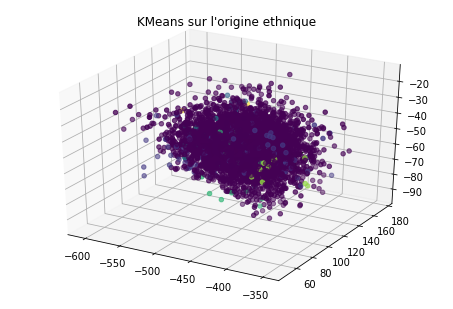

In [102]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3], c=y2_train)
ax.scatter(Centroids[:, 0], Centroids[:, 1], Centroids[:, 2], Centroids[:, 3], marker='*', c='#050505', s=1000)
fig.suptitle('KMeans sur l\'origine ethnique')


l'on n'arrive quand même à voir que la race WTH est la race dominante

Variances: 
 [0.53991399 0.15571197]
Scores prédits: 
 [[-73.48385212 -15.48214502]
 [-43.0058854  -25.01337175]
 [-52.23262072 -32.66290766]
 ...
 [-19.32330169 -14.96136426]
 [-26.6347508   -3.29649215]
 [-53.64408126   1.88707115]]


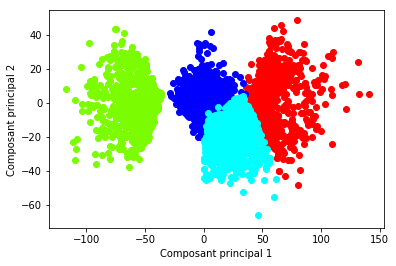

Coordonnées des variables: 
 [[-9.87738832e-01 -1.75125654e-02  5.01186261e-02  6.97961953e-02
  -2.19573572e-02  7.92918980e-02 -7.07947202e-03  4.61453437e-02
   3.44948814e-02 -6.61451638e-03  2.85049970e-02  4.73256589e-04
   3.03823581e-03  1.11209425e-02  1.61217993e-02 -9.37447818e-03
   2.01813967e-02  1.21291157e-02 -6.96840699e-03  1.45139193e-02
   5.89913558e-03  1.91960981e-03  3.15130162e-03  1.14300808e-02
   1.56414738e-03  6.75138255e-03  1.11064769e-02  7.36814097e-03
   1.29905670e-02  1.29574020e-02  1.45907270e-02  1.73700639e-02
   2.26948482e-02  2.28574023e-02  2.51645089e-02  2.25569519e-02
   2.01455784e-02  1.69112179e-02  1.22270838e-02  1.07446400e-02]
 [ 5.75830906e-02 -8.58134508e-01  3.54036727e-02  7.09688780e-02
  -2.59995727e-01 -5.85390109e-03 -6.70094903e-02 -8.39615575e-03
   1.01049206e-01 -8.87751534e-02 -3.12782527e-02  2.82386829e-02
  -8.95542390e-02  4.63887155e-02 -4.32096414e-03 -9.59242723e-02
   5.54699998e-02  6.22023478e-03 -3.86709556e

In [105]:
#ACP: décomposition du jeu de données
from sklearn.decomposition import PCA
acp = PCA(n_components=2) # retenir les 2 composantes
score_acp = acp.fit_transform(X_train) # prédiction des scores des deux facteurs retenus

print('Variances: \n', acp.explained_variance_ratio_) # variances expliquées 

print('Scores prédits: \n', score_acp) # scores prédits sur les 2 composantes obtenues

for couleur,k in zip(['red','blue','lawngreen','aqua'],[0,1,2,3]):
    plt.scatter(score_acp[kmeans.labels_==k,0],score_acp[kmeans.labels_==k,1],c=couleur)

plt.xlabel('Composant principal 1') 
plt.ylabel('Composant principal 2')
fig.suptitle('ACP du jeu de données')
#for i,label in enumerate(df_train.index):
 #plt.annotate(label,(score_acp[i,0],score_acp[i,1]))
plt.show()
#plt.cla()
#plt.clf()
#plt.close()

#projection des clusters dans le plan factoriel avec un code couleur différent selon le groupe
#remarquer le rôle de zip() dans la boucle for

#Affichage des variables sur les axes (corrélation des variables avec les axes) 
print('Coordonnées des variables: \n', acp.components_ ) 




# RANDOM FOREST

Utilisons tout d'abord un algorithme de random forest( algorithme de classification qui réduit la variance des prévisions d’un arbre de décision seul, améliorant ainsi leurs performances) pour faire une prédiction sur le sexe

In [60]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y1_train)
y_rf = rf.predict(X_test)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [61]:
rf_score = accuracy_score(y1_test, y_rf)
print(rf_score) 
#La mesure de pertinence compte le nombre de fois où l'algorithme a fait une bonne prédiction (en pourcentage) 

0.9732142857142857


In [62]:
print(metrics.classification_report(y1_test, y_rf))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1120
           1       0.98      0.94      0.96       560

   micro avg       0.97      0.97      0.97      1680
   macro avg       0.97      0.96      0.97      1680
weighted avg       0.97      0.97      0.97      1680



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


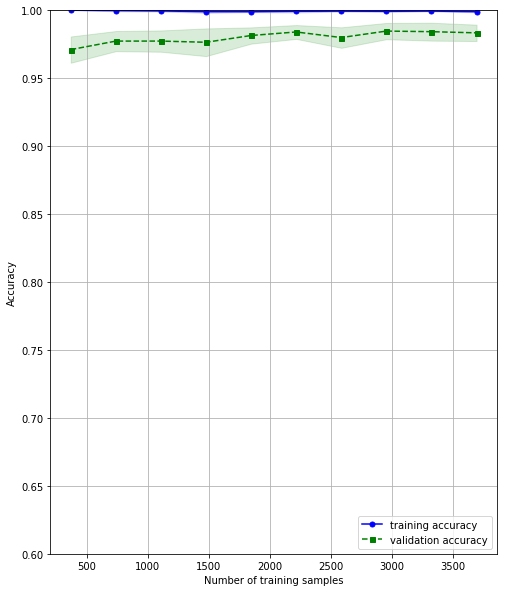

In [63]:
utils.plot_learning_curve(rf, X_train, y1_train)

In [64]:
importances = rf.feature_importances_
print(importances)
indices = np.argsort(importances)
print(indices)

[0.00240487 0.00269439 0.00189945 0.00072006 0.00704349 0.00186966
 0.000732   0.00175907 0.00398918 0.00247722 0.0028495  0.00191802
 0.01387627 0.00384766 0.0012915  0.00664448 0.00246331 0.00190831
 0.0018372  0.00093044 0.00393357 0.0042197  0.0013477  0.00614171
 0.00703869 0.00417127 0.01196919 0.01293841 0.01421994 0.01658564
 0.00778861 0.0758591  0.01636829 0.1658403  0.18200829 0.08059932
 0.15323836 0.15918743 0.00400524 0.00938315]
[ 3  6 19 14 22  7 18  5  2 17 11  0 16  9  1 10 13 20  8 38 25 21 23 15
 24  4 30 39 26 27 12 28 32 29 31 35 36 37 33 34]


IndexError: index 6 is out of bounds for axis 1 with size 6

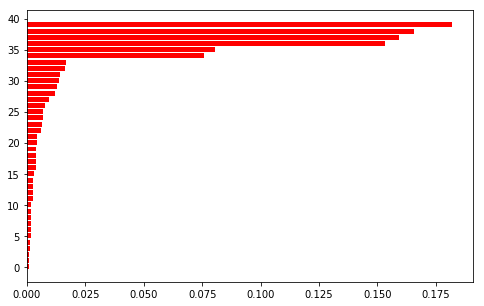

In [65]:
plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), df_train.columns[indices])
plt.title('Importance des caracteristiques')

# Random forest sur la race

In [66]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y2_train)
y_rf = rf.predict(X_test)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [67]:
rf_score = accuracy_score(y2_test, y_rf)
print(rf_score)

0.9702380952380952


In [68]:
print(metrics.classification_report(y2_test, y_rf))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1630
         1.0       0.00      0.00      0.00        40
         2.0       0.00      0.00      0.00        10

   micro avg       0.97      0.97      0.97      1680
   macro avg       0.32      0.33      0.33      1680
weighted avg       0.94      0.97      0.96      1680



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


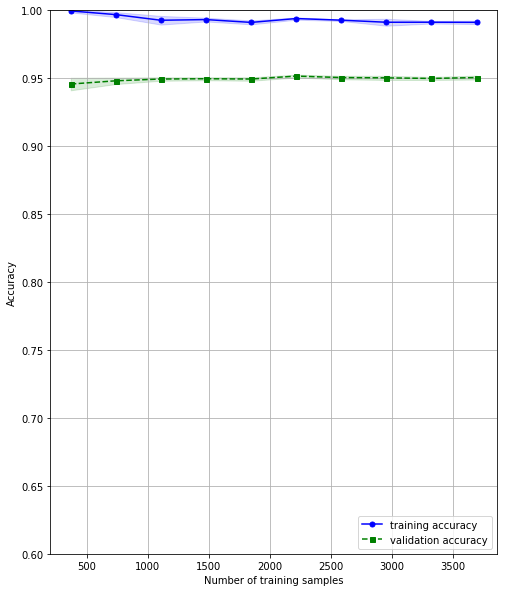

In [69]:
utils.plot_learning_curve(rf, X_train, y2_train)

In [70]:
importances = rf.feature_importances_
print(importances)
indices = np.argsort(importances)
print(indices)

[0.04062688 0.0271171  0.03084931 0.02431191 0.01980973 0.02188229
 0.01865802 0.02763404 0.03076119 0.0277808  0.02441385 0.03655564
 0.03744001 0.031795   0.02246918 0.02109448 0.02288948 0.02560608
 0.02426475 0.02428551 0.01630837 0.01783975 0.02698693 0.02639115
 0.02719675 0.02554029 0.02507284 0.02197248 0.01811626 0.02707337
 0.02325116 0.01087996 0.0206237  0.01243059 0.0129028  0.0288102
 0.02918189 0.02747405 0.03741181 0.02429037]
[31 33 34 20 21 28  6  4 32 15  5 27 14 16 30 18 19 39  3 10 26 25 17 23
 22 29  1 24 37  7  9 35 36  8  2 13 11 38 12  0]


IndexError: index 31 is out of bounds for axis 1 with size 6

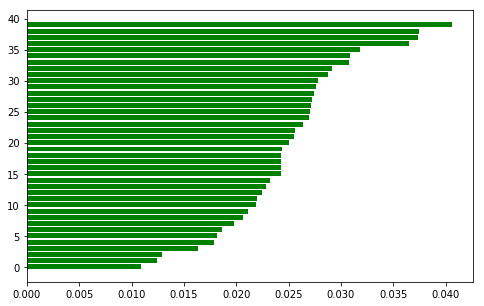

In [71]:
plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), df_train.columns[indices])
plt.title('Importance des caracteristiques')

# Random Forest sur la region

In [72]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y3_train)
y_rf = rf.predict(X_test)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [73]:
rf_score = accuracy_score(y3_test, y_rf)
print(rf_score)

0.18273809523809523


In [74]:
print(metrics.classification_report(y3_test, y_rf))

              precision    recall  f1-score   support

         0.0       0.16      0.12      0.14       160
         1.0       0.09      0.08      0.08       170
         2.0       0.21      0.34      0.26       320
         4.0       0.19      0.12      0.14       380
         5.0       0.25      0.19      0.21       390
         6.0       0.14      0.18      0.16       260

   micro avg       0.18      0.18      0.18      1680
   macro avg       0.17      0.17      0.17      1680
weighted avg       0.19      0.18      0.18      1680



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


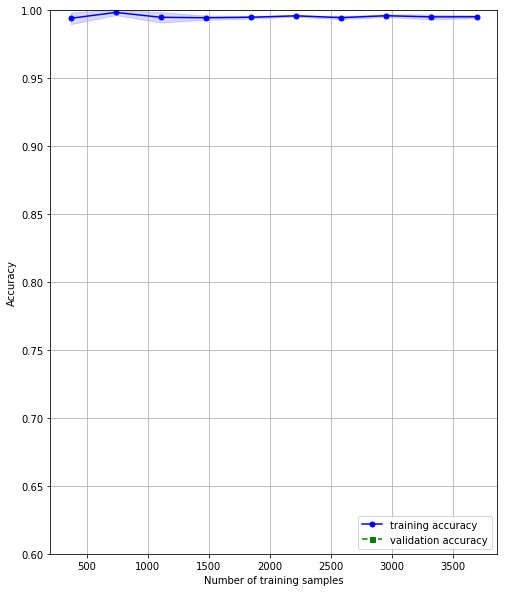

In [75]:
utils.plot_learning_curve(rf, X_train, y3_train)

In [76]:
importances = rf.feature_importances_
print(importances)
indices = np.argsort(importances)
print(indices)

[0.03442852 0.02420742 0.02809059 0.0249115  0.02078222 0.02327681
 0.0250774  0.02746573 0.0284116  0.02785785 0.02326456 0.02770061
 0.02488128 0.02860153 0.02411873 0.02486304 0.02179108 0.02549165
 0.0264086  0.02774303 0.02780076 0.02523421 0.02193604 0.02184599
 0.02770466 0.02188509 0.0238265  0.02402555 0.02582994 0.02434667
 0.02254049 0.02359007 0.02276326 0.02617795 0.02050136 0.02309666
 0.02278118 0.0264024  0.0236195  0.02471797]
[34  4 16 23 25 22 30 32 36 35 10  5 31 38 26 27 14  1 29 39 15 12  3  6
 21 17 28 33 37 18  7 11 24 19 20  9  2  8 13  0]


IndexError: index 34 is out of bounds for axis 1 with size 6

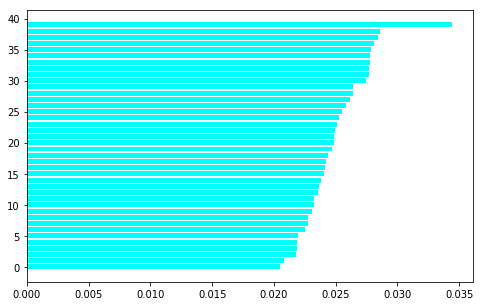

In [77]:
plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices], color='aqua', align='center')
plt.yticks(range(len(indices)), df_train.columns[indices])
plt.title('Importance des caracteristiques')

# Random forest par age

In [78]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y4_train)
y_rf = rf.predict(X_test)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [79]:
rf_score = accuracy_score(y4_test, y_rf)
print(rf_score)

0.08988095238095238


In [80]:
print(metrics.classification_report(y4_test, y_rf))

              precision    recall  f1-score   support

        20.0       0.00      0.00      0.00         0
        21.0       0.00      0.00      0.00        10
        22.0       0.02      0.07      0.03        30
        23.0       0.07      0.13      0.09       170
        24.0       0.11      0.19      0.14       190
        25.0       0.14      0.21      0.17       200
        26.0       0.10      0.19      0.14       110
        27.0       0.13      0.08      0.10       170
        28.0       0.05      0.03      0.04        70
        29.0       0.07      0.08      0.07        60
        30.0       0.04      0.02      0.03       100
        31.0       0.03      0.01      0.02        80
        32.0       0.06      0.01      0.02        80
        33.0       0.08      0.07      0.07        30
        34.0       0.00      0.00      0.00        40
        35.0       0.00      0.00      0.00        50
        36.0       0.00      0.00      0.00        20
        37.0       0.00    

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetric

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


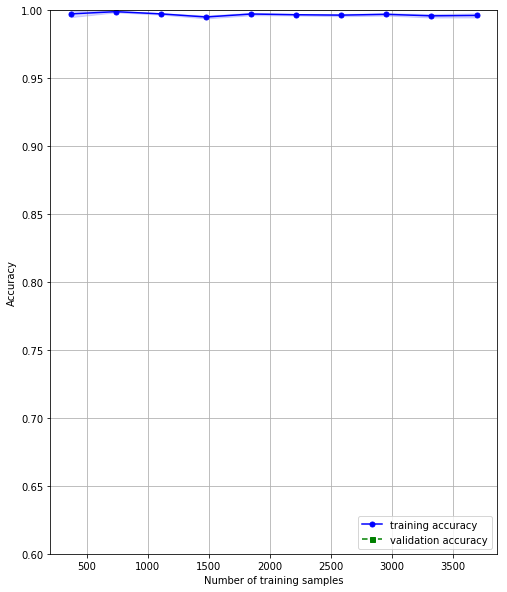

In [81]:
utils.plot_learning_curve(rf, X_train, y4_train)

In [82]:
importances = rf.feature_importances_
print(importances)
indices = np.argsort(importances)
print(indices)

[0.03361097 0.02251597 0.02568601 0.02237646 0.02231261 0.02476398
 0.02527005 0.02521878 0.02794617 0.02719564 0.02641396 0.02557874
 0.02632425 0.02650097 0.02698384 0.02515362 0.02579159 0.02559371
 0.02844509 0.02601141 0.02655435 0.02671219 0.02395168 0.02808357
 0.02151203 0.02575453 0.02225408 0.02388101 0.02586849 0.02428588
 0.02399462 0.02210383 0.02343896 0.0218321  0.02456813 0.0231131
 0.02351158 0.02129703 0.02282591 0.02476313]
[37 24 33 31 26  4  3  1 38 35 32 36 27 22 30 29 34 39  5 15  7  6 11 17
  2 25 16 28 19 12 10 13 20 21 14  9  8 23 18  0]


IndexError: index 37 is out of bounds for axis 1 with size 6

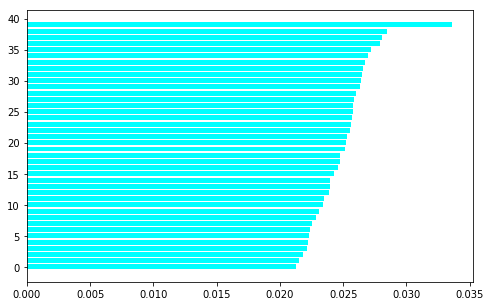

In [83]:
plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices], color='aqua', align='center')
plt.yticks(range(len(indices)), df_train.columns[indices])
plt.title('Importance des caracteristiques')

Essayons de voir l'ensemble des corrélations entre les différentes variables

In [84]:
dfcor = df_train.corr()
print(dfcor)

                         gender    region       age      race  \
gender                 1.000000 -0.036963 -0.038379 -0.048252   
region                -0.036963  1.000000  0.011306 -0.036314   
age                   -0.038379  0.011306  1.000000  0.008617   
race                  -0.048252 -0.036314  0.008617  1.000000   
younger_than_mean_age  0.069362  0.005581 -0.766554 -0.008835   

                       younger_than_mean_age  
gender                              0.069362  
region                              0.005581  
age                                -0.766554  
race                               -0.008835  
younger_than_mean_age               1.000000  


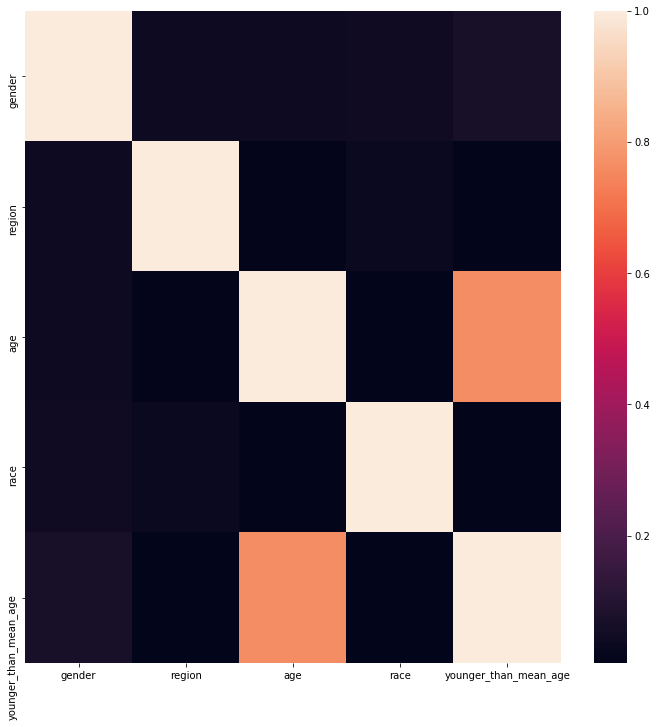

In [85]:
plt.figure(figsize=(12,12))
sns.heatmap(abs(df_train.corr()))

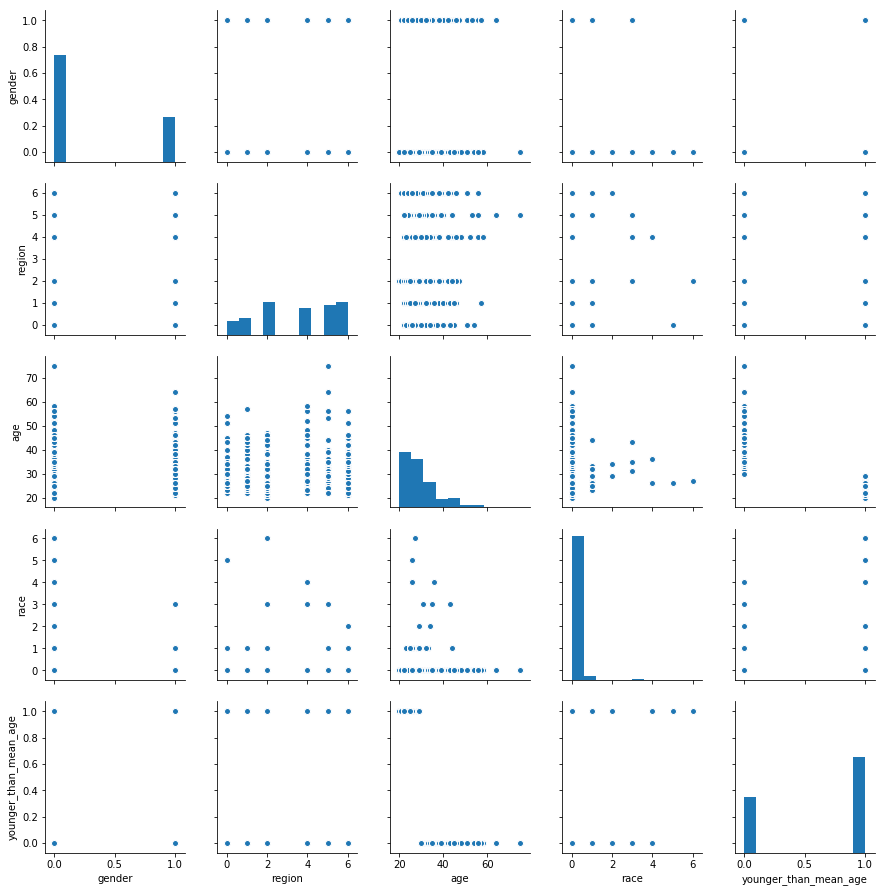

In [86]:
sns.pairplot(df_train) 
# pairplot affiche les nuages de points associés à tous les couples de paramètres :

In [ ]:
sns.jointplot(df_train.race, df_train.region,df_train.gender, df_train.age)


# Clustering Hiérarchique

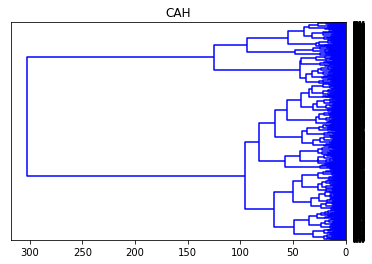

In [89]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage #librairies pour la CAH
#générer la matrice des liens
# il vaut lieux standardiser d'abord les variables:
from sklearn.preprocessing import StandardScaler
X_train_std = StandardScaler().fit_transform(X_train)
Z = linkage(X_train_std,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.title("CAH")
dendrogram(Z,labels=df_train.index,orientation='left',color_threshold=0
,show_leaf_counts=True) # right, left bottom et top
plt.show()